In [1]:
import json
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import torch
from torchvision import transforms as T

from models import FRCNN, StackedHourglass, fasterrcnn_backbone
from bop_dataset import BOPDataset
from poseOpt import pose_coordinate_descend

from train.transforms import ToTensor, Normalize, AffineCrop, Normalize_imgnet
from misc.pose2d_eval import Pose2DEval
from bop_toolkit_lib.inout import save_bop_results

In [2]:
# Load dataset meta 
num_classes = {'lmo':8, 'ycbv': 21, 'tudl': 3} 

root = './data/bop'
dataset_name = 'lmo'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

dataset = BOPDataset(root, dataset_name, split='test', 
                     return_keypoints=False, return_coco=True)
dataset._set_kpts_info()

## detection

In [3]:
# Load Faster-RCNN detector
detector_trainsform = T.ToTensor()
state_dict = torch.load('data/detect_checkpoints/d{}.pt'.format(dataset_name), map_location=device)['frcnn']

detector = fasterrcnn_backbone('resnet101', num_classes=1+num_classes[dataset_name]).to(device)
detector.eval()
detector.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
i = 120
image = dataset[i]['image']

with torch.no_grad():
    img = detector_trainsform(image).to(device)
    pred = detector([img])[0]
    pred = {k:v.cpu() for k,v in pred.items()}

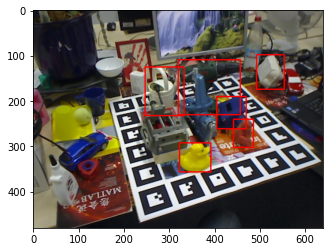

In [5]:
boxes = pred['boxes'].int().numpy()
scores = pred['scores']

img_box = np.array(image)
for bb, s in zip(boxes, scores):
    if s > 0.95:
        img_box = cv2.rectangle(img_box, (bb[0], bb[1]), (bb[2], bb[3]), (255,0,0), thickness=2)

plt.rcParams['figure.figsize']=6,4
plt.imshow(img_box)

## keypoints (w. gt box)
(For full pipeline, please refer to est_6dof.py)

In [6]:
# Load keypoints detector
transform_list = []
transform_list.append(AffineCrop(out_size=256, scale_factor=0, rotation_factor=0, dialation=0.25))
transform_list.append(ToTensor())
transform_list.append(Normalize())
kpts_transform = T.Compose(transform_list)
state_dict = torch.load('data/kpts_checkpoints/{}.pt'.format(dataset_name), map_location=device)['stacked_hg']

kpts_detector = StackedHourglass(dataset.n_kpts).to(device)
kpts_detector.eval()
kpts_detector.load_state_dict(state_dict)

# Object idx
obj2idx = dataset.obj2idx
idx2obj = {v:k for k,v in obj2idx.items()}
lab2obj = {v+1:k for k,v in obj2idx.items()}

poseEval = Pose2DEval()

In [7]:
i = 120
sample = dataset[i]
meta = dataset.db[i]  # contain all ground truth pose as well as camera instrinsic

image = sample['image']
gt_boxes = sample['boxes']
gt_objs = [lab2obj[l] for l in sample['labels']]

# Keypoint-base detection
kpts = []
bboxes = []
objs = []
confidence = []

for obj, box in zip(gt_objs, gt_boxes):
    box = [box[0], box[1], box[2]-box[0], box[3]-box[1]]
    input_crop = {'image':image, 'bb':box}
    input_crop = kpts_transform(input_crop)
    
    with torch.no_grad():
        batch = input_crop['image'][None].to(device)
        output = kpts_detector(batch)
        output = output[-1].cpu()
    
    kpt_start = dataset.obj2kptid[obj][0]
    kpt_end = dataset.obj2kptid[obj][1]
    heatmaps_pred = output[[0], kpt_start:kpt_end, :, :]

    kpts_pred, confs = poseEval.heatmaps_to_locs(heatmaps_pred, return_vals=True)
    confs = confs[0]
    kpts_pred = kpts_pred[0]

    crop_kpts = kpts_pred * (256/64)
    view_kpts = poseEval.get_view_kpts(box, crop_kpts)
    view_kpts = view_kpts.numpy()
    
    kpts.append(view_kpts)
    bboxes.append(box)
    objs.append(obj)
    confidence.append(confs)

In [8]:
import matplotlib.cm as cm
from utils.img_utils import draw_kpts

colors = cm.Set2(np.linspace(0, 1, 8))
obj2color = {1:0, 5:1, 6:2, 8:3, 9:4, 10:5, 11:6, 12:7}

img = np.array(image)
for i, box in enumerate(bboxes):
    obj = objs[i]
    color = colors[obj2color[obj]]
    img_box = cv2.rectangle(img, box[:2], [box[0]+box[2], box[1]+box[3]], 
                            thickness=2, color=color[:3]*350)

img_kpts = img.copy()
for i, kpt in enumerate(kpts):
    obj = objs[i]
    color = colors[obj2color[obj]]
    img_kpts = draw_kpts(img_kpts, kpt, r=1, thickness=5, color=color[:3]*400)

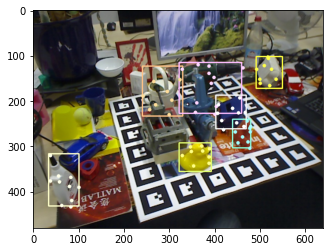

In [9]:
plt.imshow(img_kpts)

## 6D pose optimization with pred keypoints

In [10]:
import trimesh
from utils.trimesh_renderer import trimesh_renderer

obj_dir = 'data/bop/lmo/models'
objfiles = sorted(glob(obj_dir + '/*.ply'))
objids = [int(file.split('_')[-1].split('.')[0]) for file in objfiles]

mesh_collection = {}
for objid, objfile in zip(objids, objfiles):
    mesh_collection[objid] = trimesh.load(objfile)

In [11]:
# Estimate 6D pose
with open('kpts3d.json', 'r') as infile:
    kpts3d = json.load(infile)[dataset.dataset_name]

K = meta['K']

R_list = []
t_list = []
obj_list = []
for i in range(len(objs)):
    obj = objs[i]
    conf = confidence[i]
    view_kpts = kpts[i]
    
    D = conf.numpy().astype(np.double)
    kpts3d_obj = kpts3d[str(obj)]
    kpts_h = np.hstack([view_kpts, np.ones([view_kpts.shape[0], 1])]).astype(np.double)
    
    R_, t_, Z_, res = pose_coordinate_descend(K, kpts_h, kpts3d_obj, D, 
                                              max_iters=10000, thresh=1e-6, pnp_int=True)
    
    R_list.append(R_)
    t_list.append(t_)
    obj_list.append(obj)

In [12]:
# Render 3D models
K = meta['K']
fx, fy = K[0,0], K[1,1]
cx, cy = K[0,2], K[1,2]
renderer = trimesh_renderer(img_w=640, img_h=480)

meshes = [mesh_collection[idx].copy() for idx in obj_list]
img3d = np.array(image)
out = renderer.render_scene(meshes, R_list, t_list, image=img3d, 
                                fx=fx, fy=fy, cx=cx, cy=cy)

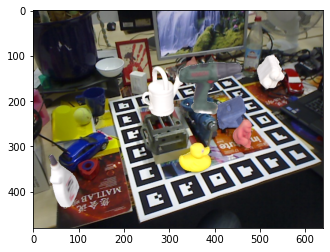

In [13]:
plt.imshow(out)